Initial explanation about the project.

Since our dataset is already preprocessed we can just simply import the desired tools and load the data. First we will analyse our dataset.

In [23]:
import pandas as pd
import numpy as np
import time
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency



dataframe = pd.read_csv('data.csv')

#dataframe.info()
dataframe.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


Now we will check the distrubution of our target variable.

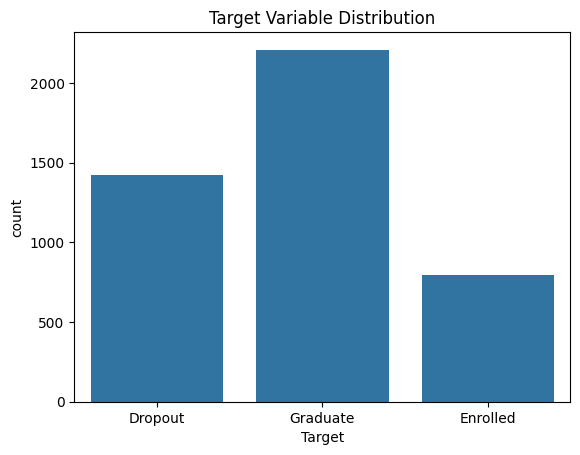

In [24]:
sea.countplot(x='Target', data = dataframe)
plt.title('Target Variable Distribution')
plt.show()

We should also consider the correlation between numerical variables. Let's check it out

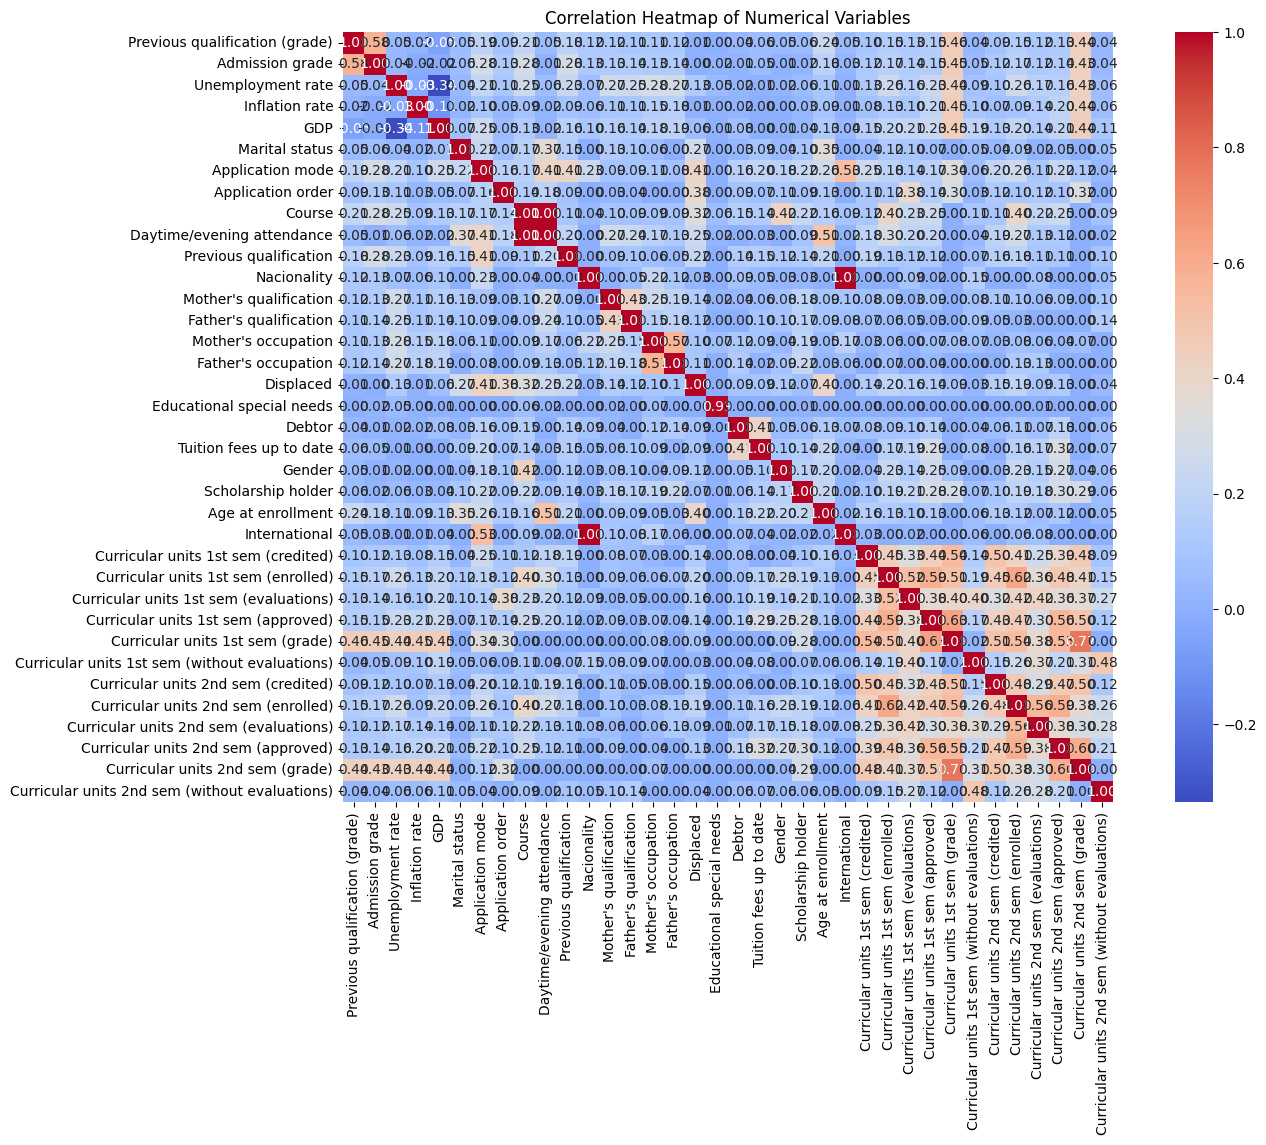

In [25]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def correlation_ratio(categorical, continuous):
    categories = categorical.unique()
    group_means = [continuous[categorical == cat].mean() for cat in categories]
    overall_mean = continuous.mean()
    numerator = sum([(mean - overall_mean)**2 * len(categorical[categorical == cat]) for cat, mean in zip(categories, group_means)])
    denominator = sum((continuous - overall_mean)**2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

continous_features = ["Unemployment rate", "Inflation rate", "GDP", "Previous qualification (grade)", "Admission grade"]

get_columns = dataframe.select_dtypes(include=['number']).columns

continous_coluns = []
non_continous_coluns = []

for col in get_columns:
    if col in continous_features:
        continous_coluns.append(col)
    else:
        non_continous_coluns.append(col)

num_cols = len(continous_coluns) + len(non_continous_coluns)
all_cols = continous_coluns+non_continous_coluns

correlation_matrix = pd.DataFrame(index=all_cols, columns=all_cols, dtype=float)

for x in all_cols:
    for y in all_cols:
        if x in continous_coluns and y in continous_coluns:
            # Pearson for continuous-continuous
            correlation_matrix.loc[x, y] = dataframe[x].corr(dataframe[y])
        elif x in non_continous_coluns and y in non_continous_coluns:
            # Cramer's V for categorical-categorical
            correlation_matrix.loc[x, y] = cramers_v(dataframe[x], dataframe[y])
        else:
            # Correlation Ratio for mixed
            if x in continous_coluns:
                correlation_matrix.loc[x, y] = correlation_ratio(dataframe[y], dataframe[x])
            else:
                correlation_matrix.loc[x, y] = correlation_ratio(dataframe[x], dataframe[y])
  


plt.figure(figsize=(16, 10))
sea.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


However, this does not look good, we can't interpret it. Let's put a trehshold, so that only varaibles above the threshold are considered and shown.

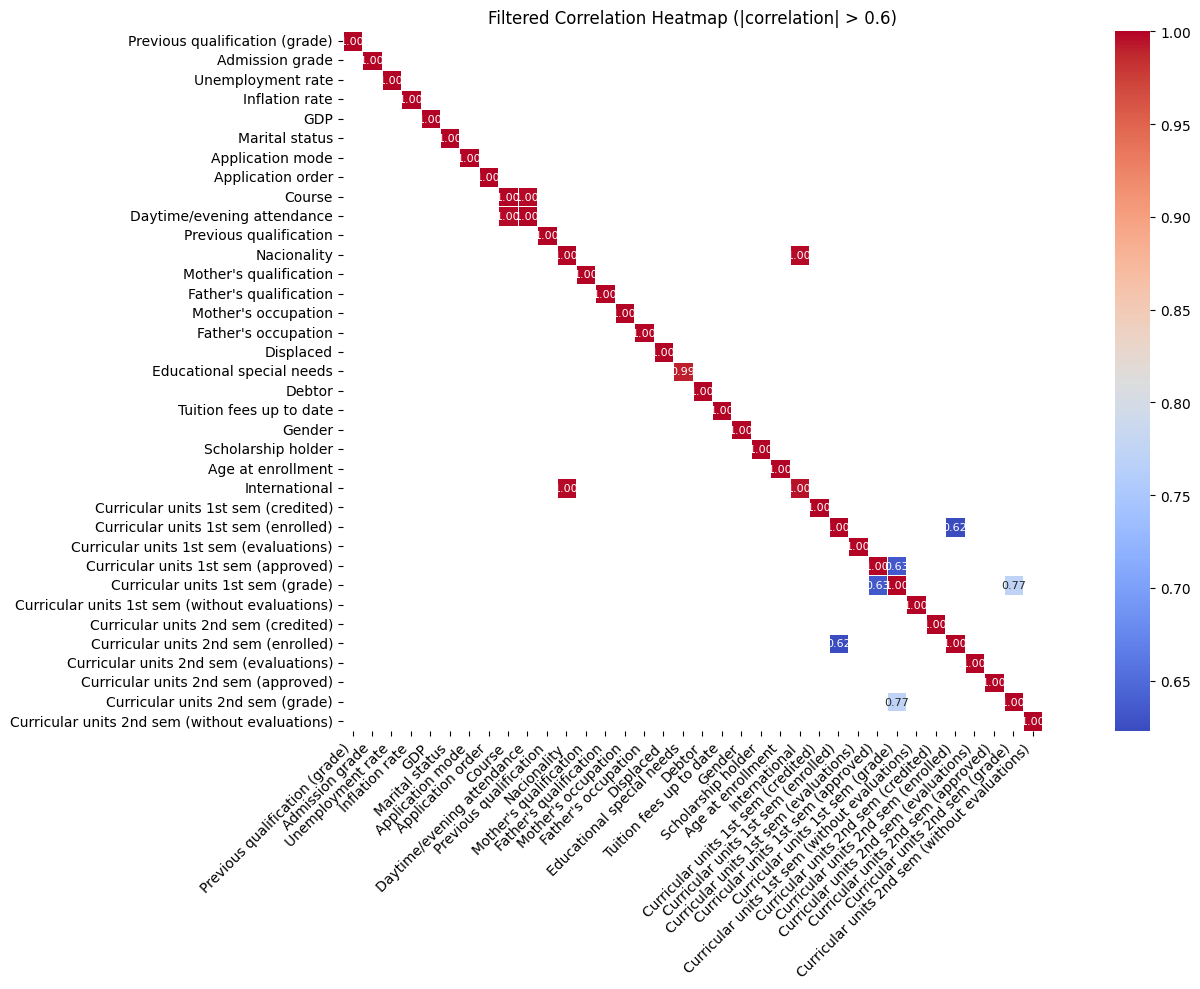

In [26]:
threshold = 0.6
mask = (abs(correlation_matrix) < threshold)

plt.figure(figsize=(16, 10))
sea.heatmap(correlation_matrix.mask(mask), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, square=True, linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title(f'Filtered Correlation Heatmap (|correlation| > {threshold})')
plt.tight_layout()
plt.show()

We wanna see the correlation between our variables and our target variable, however, our target is a string, so will have to encode it. 
After encoding our target variable we will set our X and Y axis.

In [27]:
le = LabelEncoder()

dataframe['Target'] = le.fit_transform(dataframe['Target'])

x_axis = dataframe.drop('Target', axis=1)
y_axis = dataframe['Target']


Since our target is now encoded we can check the correlation between varaibles and the target.

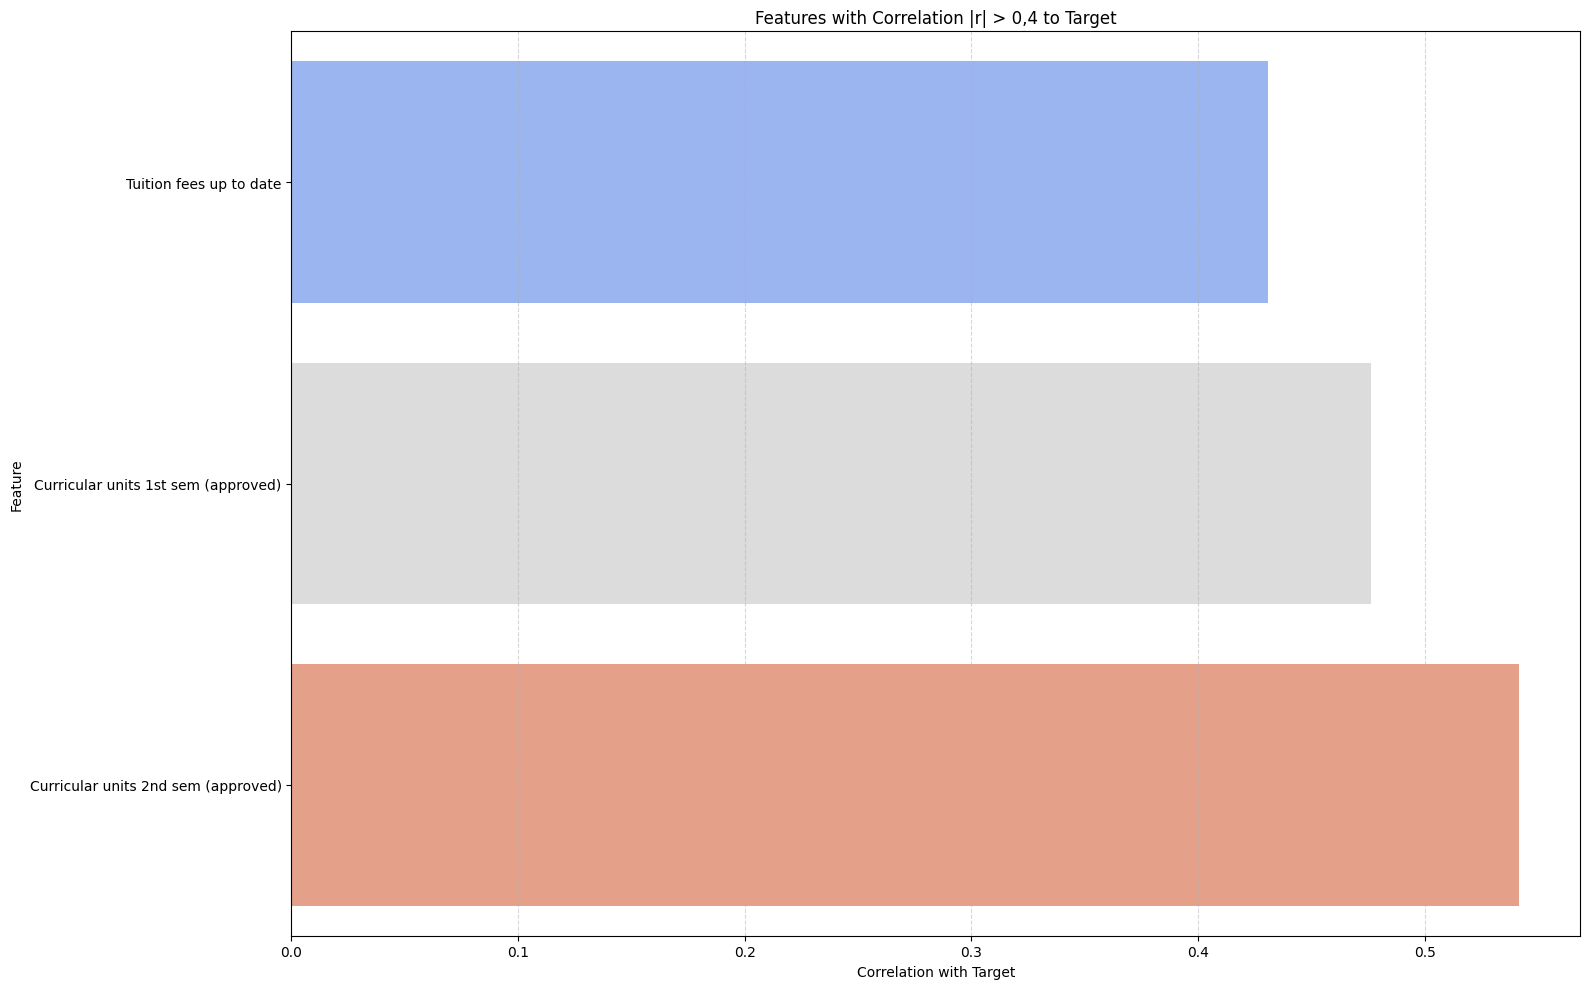

In [28]:
target_relation = pd.DataFrame(index=all_cols, columns=['Association'], dtype=float)

for col in all_cols:
    if col in continous_coluns:
        target_relation.loc[col, 'Association'] = correlation_ratio(dataframe['Target'], dataframe[col])
    else:
        target_relation.loc[col, 'Association'] = cramers_v(dataframe[col], dataframe['Target'])

strong_correlations = target_relation[target_relation['Association'].abs() > 0.4].copy()

plt.figure(figsize=(16, 10))
sea.barplot(x=strong_correlations['Association'], y=strong_correlations.index, palette='coolwarm', hue=strong_correlations.index, legend=False)
plt.title(f'Features with Correlation |r| > 0,4 to Target')
plt.xlabel('Correlation with Target')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

As we can see, Tuition fees up to date, Curricular units 1nd sem (approved) and Curricular units 2nd sem (approved) are the most impactant features in relation with the Target.

Now we split our data between training and testing. Since our target class is imbalanced, we use SMOTE to help smooth it out.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.2, random_state=40, stratify=y_axis)

The next step is to train our first model which is a Decision Tree Classifier.

In [130]:
clf = DecisionTreeClassifier( 
    criterion='gini',        # or 'entropy'
    max_depth=5,            # Limit tree depth to avoid overfitting
    min_samples_split=6,     # Min samples to split an internal node
    min_samples_leaf=6,      # Min samples at a leaf node
    random_state=40)

start_train_dt = time.time()
clf.fit(x_train , y_train)
end_train_dt = time.time()

We test our Decision Tree with the X axis test data.

In [131]:
start_test_dt = time.time()
y_pred_dt = clf.predict(x_test)
end_test_dt = time.time()

Finally we check wether our Decision Tree was sucessful or not and categorize it in several metrics.

Acuracy: 0.7638
Precision: 0.7588
Recall: 0.7638
F1-Score: 0.7459
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       284
           1       0.60      0.34      0.43       159
           2       0.75      0.96      0.84       442

    accuracy                           0.76       885
   macro avg       0.74      0.67      0.68       885
weighted avg       0.76      0.76      0.75       885

Training time: 0.0220 seconds
Testing time: 0.0028 seconds


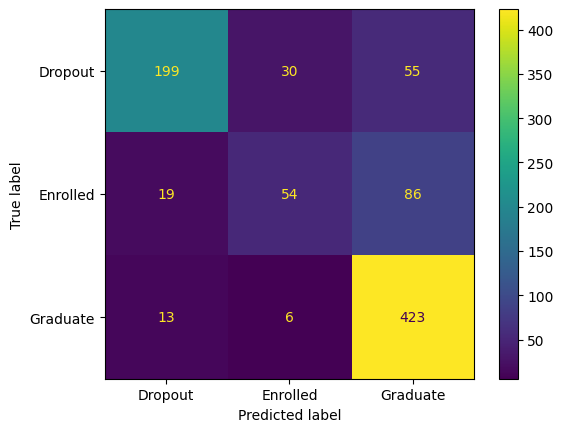

In [132]:
accuracy_dt = skl.metrics.accuracy_score(y_test, y_pred_dt)
precision_dt = skl.metrics.precision_score(y_test, y_pred_dt, average="weighted", zero_division=0)
recal_dt = skl.metrics.recall_score(y_test, y_pred_dt, average="weighted", zero_division=0)
f1_score_dt = skl.metrics.f1_score(y_test, y_pred_dt, average="weighted", zero_division=0)
confusion_matrix_dt = skl.metrics.confusion_matrix(y_test,y_pred_dt)


print(f"Acuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recal_dt:.4f}")
print(f"F1-Score: {f1_score_dt:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred_dt, zero_division=0))
print(f"Training time: {end_train_dt-start_train_dt:.4f} seconds")
print(f"Testing time: {end_test_dt-start_test_dt:.4f} seconds")



Here's the visual representation of the Decision Tree.

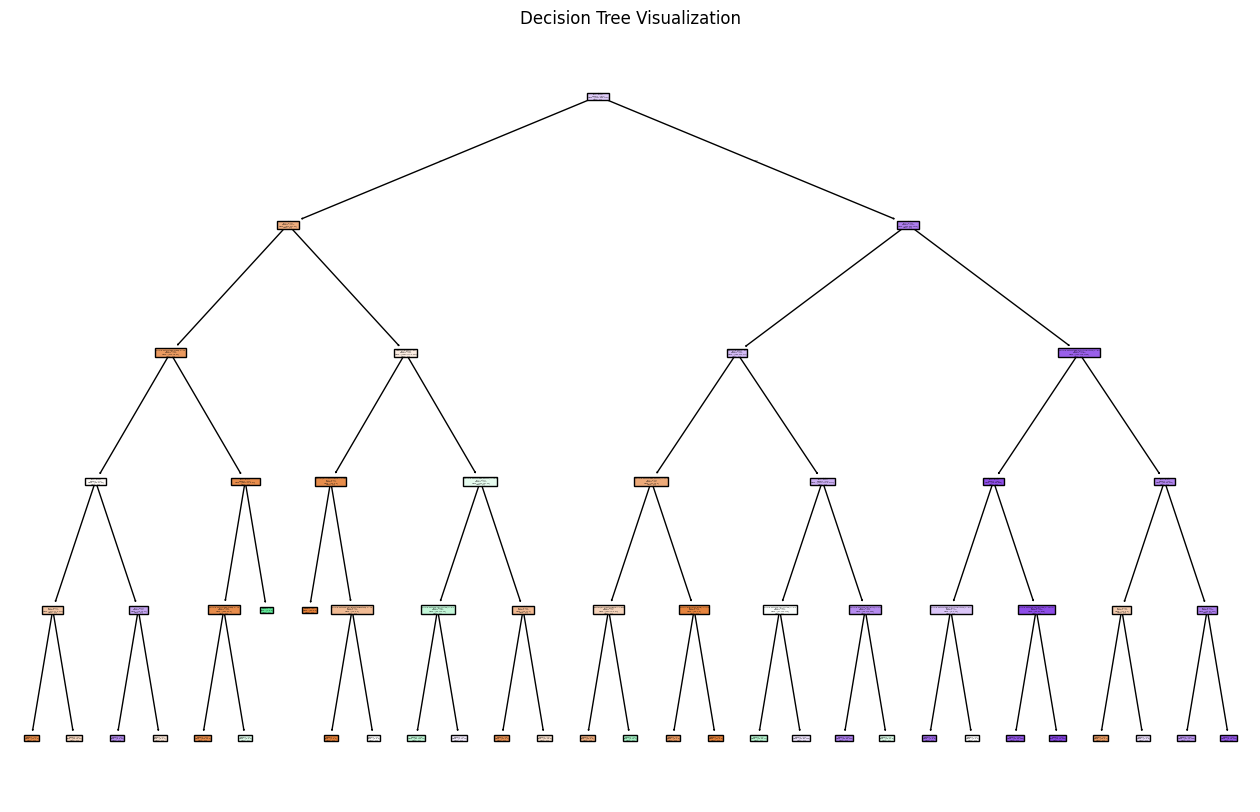

In [94]:
plt.figure(figsize=(16,10))
skl.tree.plot_tree(clf, filled=True, feature_names=x_axis.columns, class_names=True)
plt.title("Decision Tree Visualization")
plt.show()

Now we will train our second model, Neural Networks.

In [168]:


cat_indices = [dataframe.columns.get_loc(x) for x in non_continous_coluns]
smote = SMOTENC(categorical_features=cat_indices, 
                random_state=40)


x_train_smoted, y_train_smoted = smote.fit_resample(x_train, y_train)

mlp = MLPClassifier(hidden_layer_sizes=(128,64,32),
                    activation='relu', 
                    solver='adam', 
                    batch_size=64,
                    max_iter=2000,
                    learning_rate_init=0.001,
                    alpha=0.00005,
                    early_stopping=True, 
                    random_state=40)

start_train_nn = time.time()
mlp.fit(x_train_smoted , y_train_smoted)
end_train_nn = time.time()

TODO:

In [169]:
start_test_nn = time.time()
y_pred_nn = mlp.predict(x_test)
end_test_nn = time.time()

TODO:

Acuracy: 0.6859
Precision: 0.7636
Recall: 0.6859
F1-Score: 0.7057
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.58      0.70       284
           1       0.36      0.67      0.47       159
           2       0.84      0.76      0.80       442

    accuracy                           0.69       885
   macro avg       0.69      0.67      0.65       885
weighted avg       0.76      0.69      0.71       885

Training time: 7.9323 seconds
Testing time: 0.0047 seconds


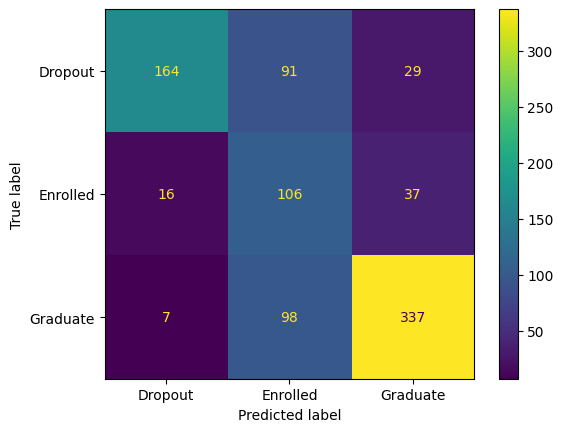

In [170]:
accuracy_nn = skl.metrics.accuracy_score(y_test, y_pred_nn)
precision_nn = skl.metrics.precision_score(y_test, y_pred_nn, average="weighted", zero_division=0)
recal_nn = skl.metrics.recall_score(y_test, y_pred_nn, average="weighted", zero_division=0)
f1_score_nn = skl.metrics.f1_score(y_test, y_pred_nn, average="weighted", zero_division=0)
confusion_matrix_nn = skl.metrics.confusion_matrix(y_test,y_pred_nn)


print(f"Acuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recal_nn:.4f}")
print(f"F1-Score: {f1_score_nn:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_nn, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred_nn, zero_division=0))
print(f"Training time: {end_train_nn-start_train_nn:.4f} seconds")
print(f"Testing time: {end_test_nn-start_test_nn:.4f} seconds")

In [ ]:
# comparar variaáveis:
#  - binárias com binárias
#  - binárias com categoricas
#  - categoricas com categoricas
#  - continuas com continuas
#  - categoricas com continuas
#  - binárais com contiuas

# restringir o scaler a variáveis apenas continuas 


SyntaxError: invalid syntax (3144166991.py, line 1)